# Mismatch Parameter Space Animation in Google Colab

This notebook visualizes mismatch data and generates parameter space animations for gravitational wave simulations.

**Sections:**
1. Install Required Packages
2. Upload Data Files
3. Import Libraries
4. Set Parameters and Load Data
5. Define Helper Functions
6. Plotting and Animation Setup
7. Create and Display Animation

In [ ]:
# Install required packages (if not already installed)
!pip install seaborn matplotlib numpy pandas

In [ ]:
"""
Load mismatch data distributions. These contain, for the London, Cheung and TEOBPM models, the (\ell,m) mismatch values for different starting times, where (\ell,m)={(2,2),(2,1),(3,3),(3,2),(4,4)}.
"""
!wget https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz

"""
Load SXS catalog. TO each simulation, we associate to it the triplet $(\eta,\chi_{+},\chi_{-})$.
"""
!wget https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/SXS_BBH_nonprec_nonecc_all.txt


--2025-10-24 15:24:46--  https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz [following]
--2025-10-24 15:24:47--  https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583752 (570K) [application/octet-stream]
Saving to: ‘avg_mismatches_all_

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import io
import os

In [ ]:
# Set parameters and load data
npz_file = 'avg_mismatches_all_times.npz'
catalog_file = 'SXS_BBH_nonprec_nonecc_all.txt'
model = "KerrBinary_London"
modes = ['22', '21', '33', '32', '44']
mode = '22'  # <-- Change this to select the desired mode

# Load mismatch data
data = np.load(npz_file, allow_pickle=True)
avg_mismatches = data['avg_mismatches'].item()

# Load catalog
d_id_info = {}
with open(catalog_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = line.split()
        if len(parts) < 7:
            continue
        sim_id = parts[0]
        try:
            eta = float(parts[2])
            chip = float(parts[5])
            chim = float(parts[6])
            d_id_info[sim_id] = {"eta": eta, "chip": chip, "chim": chim}
        except ValueError:
            continue

In [ ]:
# Define helper functions and animation parameters
eta_input = 0.25
chip_input = 0.5
chim_input = 0.2
fixed_vals = {"eta": eta_input, "chip": chip_input, "chim": chim_input}
thresholds = np.logspace(np.log10(0.035), np.log10(0.00001), 10)

def find_first_crossing_time(t_arr, mm_arr, thresh):
    sort_idx = np.argsort(t_arr)
    t_sorted = t_arr[sort_idx]
    mm_sorted = mm_arr[sort_idx]
    for i in range(1, len(mm_sorted)):
        if mm_sorted[i] <= thresh:
            t1, t2 = t_sorted[i-1], t_sorted[i]
            m1, m2 = mm_sorted[i-1], mm_sorted[i]
            if m2 == m1:
                return t2
            slope = (m2 - m1) / (t2 - t1)
            crossing_t = t1 + (thresh - m1) / slope
            return crossing_t
    return None

<>:62: SyntaxWarning: invalid escape sequence '\%'
<>:62: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-1498568093.py:62: SyntaxWarning: invalid escape sequence '\%'
  axs[idx].set_title(f"$\\mathcal{{M}}_{{th}}={threshold*100:.1f}\%$, $(\\ell, |m|)=({int(mode[0])},{int(mode[1])})$, ${label_map[fixed_dim]}={fixed_vals[fixed_dim]:.2f}$", fontsize=22)


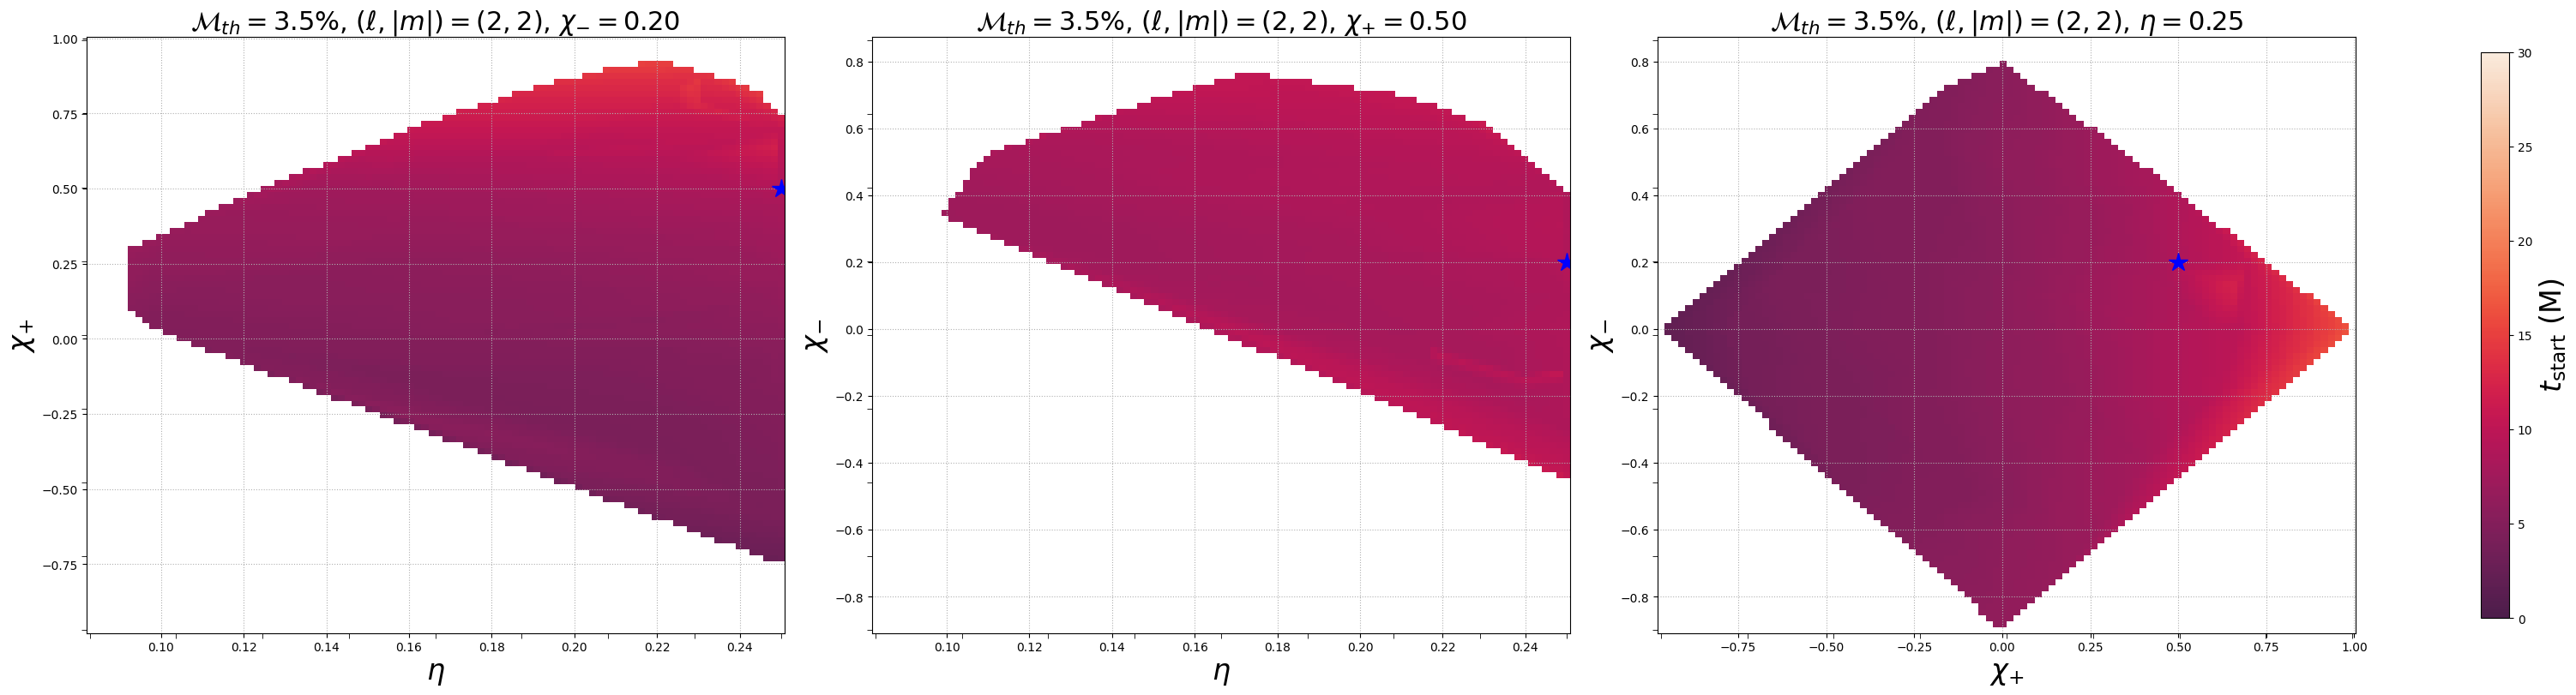

In [ ]:
# Plotting and animation setup
fig, axs = plt.subplots(1, 3, figsize=(30, 8), constrained_layout=True)
cbar_range = (0, 30)
label_map = {"eta": r"\eta", "chip": r"\chi_{+}", "chim": r"\chi_{-}"}
axis_pairs = [("eta", "chip"), ("eta", "chim"), ("chip", "chim")]
cmap = ListedColormap(sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 1, 256)))
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=cbar_range[0], vmax=cbar_range[1]))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), shrink=0.95)
cbar.set_label(r"$t_{\rm start}~(\mathrm{M})$", fontsize=24)

def update(threshold):
    for ax in axs:
        ax.clear()
    crossing_records = []
    t_start_keys = list(avg_mismatches[model][mode].keys())
    starting_times = sorted(float(t) for t in t_start_keys)
    for sim_id, params in d_id_info.items():
        mm_vs_t = []
        ts = []
        for t_start in starting_times:
            val = avg_mismatches.get(model, {}).get(mode, {}).get(t_start, {}).get(sim_id, np.nan)
            if val is not None and not np.isnan(val) and val > 0:
                ts.append(t_start)
                mm_vs_t.append(val)
        if len(ts) < 2:
            t_cross = 100.0
        else:
            ts = np.array(ts)
            mm_vs_t = np.array(mm_vs_t)
            t_cross = find_first_crossing_time(ts, mm_vs_t, threshold)
            if t_cross is None:
                t_cross = 100.0
        crossing_records.append({
            "sim_id": sim_id,
            "eta": params["eta"],
            "chip": params["chip"],
            "chim": params["chim"],
            "crossing_t": t_cross
        })
    df = pd.DataFrame(crossing_records)
    if df.empty:
        return
    points = df[["eta", "chip", "chim"]].values
    values = df["crossing_t"].values
    for idx, (x, y) in enumerate(axis_pairs):
        X_vals = np.linspace(df[x].min(), df[x].max(), 100)
        Y_vals = np.linspace(df[y].min(), df[y].max(), 100)
        X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)
        fixed_dim = ({"eta", "chip", "chim"} - {x, y}).pop()
        points_grid = np.column_stack([
            X_grid.ravel() if var == x else
            Y_grid.ravel() if var == y else
            np.full(X_grid.size, fixed_vals[fixed_dim])
            for var in ["eta", "chip", "chim"]
        ])
        interp_vals = griddata(points, values, points_grid, method='linear')
        interp_vals = interp_vals.reshape(X_grid.shape)
        axs[idx].pcolormesh(X_grid, Y_grid, interp_vals, shading='auto', cmap=cmap, vmin=cbar_range[0], vmax=cbar_range[1])
        axs[idx].set_xlabel(f"${label_map[x]}$", fontsize=24)
        axs[idx].set_ylabel(f"${label_map[y]}$", fontsize=24)
        axs[idx].set_title(f"$\\mathcal{{M}}_{{th}}={threshold*100:.1f}\%$, $(\\ell, |m|)=({int(mode[0])},{int(mode[1])})$, ${label_map[fixed_dim]}={fixed_vals[fixed_dim]:.2f}$", fontsize=22)
        axs[idx].plot(fixed_vals[x], fixed_vals[y], marker='*', markersize=16, color='blue')
        axs[idx].set_xticks(np.linspace(X_vals.min(), X_vals.max(), 9), minor=True)
        axs[idx].set_yticks(np.linspace(Y_vals.min(), Y_vals.max(), 9), minor=True)
        axs[idx].tick_params(which='minor', length=4)
        axs[idx].grid(True, which='major', ls=':')

# Create and display the animation
ani = FuncAnimation(fig, update, frames=thresholds, interval=500, blit=False)
HTML(ani.to_jshtml())

In [ ]:
# To save the gif (optional):
ani.save('interpolant_animation.gif', writer=PillowWriter(fps=2), dpi=100)